# 전이학습 
- 고양이 강아지 구분
- VGG16 (2014)
 - 이미지넷으로 사전 훈련된 네트워크를 사용
 - 1000개의 객체를 구분하는 모델이나, 여기서는 고양이, 강아지 구분에 사용  

- 1) 특성추출 방식
 - 합성곱 필터링 영역(convolutional base)를 그대로 사용
 - 공통되는 특성만 추출하여 사용한다
 - 전결합망 부분은 새로운 데이터 (고양이/강아지)로 학습을 다시 시킨다


- 2) 미세 조정 방식


## 데이터 다운로드

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, os.path, shutil
import zipfile
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

ModuleNotFoundError: No module named 'tensorflow'

## VGG16으로 사전학습된 가중치 가져오기
- include_top은 기존의 1000개 전결합망 분류기를 포함할지를 선택

In [11]:
conv_base = VGG16(weights = 'imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [12]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## 두가지 옵션이 가능하다
### 1) 합성곱 기반을 통과한 출력을 저장한 후 이를 전결합망에 통과
- 데이터 확장은 사용할 수 없다
- 실행이 빠르다

### 2) 모델에 Dense망을 추가하고 학습을 수행
- 데이터 확장을 사용할 수 있다.
- 비용이 많이 든다


### 1) 방식을 먼저 수행한다.


### 데이터 읽기

In [13]:
!curl -L \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -o ./cats_and_dogs_filtered.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.4M  100 65.4M    0     0   188M      0 --:--:-- --:--:-- --:--:--  188M


In [14]:
!unzip -q cats_and_dogs_filtered.zip

In [15]:
base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [16]:
train_dir

'./cats_and_dogs_filtered/train'

## 특성추출만 사용한 모델 (데이터 증식은 사용하지 않는 방식)
- ImageDataGenerator를 사용하여 이미지와 레이블을 생성
- conv_base 모델의 predict를 사용하여 이미지의 특성을 추출
- 마지막 출력의 크기가 (4, 4, 512)이다.


In [21]:
from keras import layers
from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
from tensorflow.keras import optimizers


In [18]:
img_width = 150
img_height = 150
batch_size=20

datagen = ImageDataGenerator(rescale = 1./255)

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory,
 	    target_size=(img_width,img_height),
      class_mode='binary',
			batch_size=batch_size)
  i=1
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i*batch_size:(i+1)*batch_size] = features_batch
    labels[i*batch_size:(i+1)*batch_size] = labels_batch
    i += 1
    if i* batch_size >= sample_count:
      break
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))

    
model = models.Sequential()

model.add(layers.Dense(512, activation='relu', input_dim= 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 4,195,329
Trainable params: 4,195,329
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data= (validation_features, validation_labels),
    batch_size=batch_size)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


100/100 [==============================] - 2s 7ms/step - loss: 0.5607 - accuracy: 0.7145 - val_loss: 0.4101 - val_accuracy: 0.8430
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - loss: 0.3892 - accuracy: 0.8385 - val_loss: 0.3375 - val_accuracy: 0.8740
Epoch 3/30
100/100 [==============================] - 0s 5ms/step - loss: 0.3334 - accuracy: 0.8565 - val_loss: 0.3090 - val_accuracy: 0.8820
Epoch 4/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2840 - accuracy: 0.8950 - val_loss: 0.3117 - val_accuracy: 0.8710
Epoch 5/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2531 - accuracy: 0.9030 - val_loss: 0.3000 - val_accuracy: 0.8660
Epoch 6/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2365 - accuracy: 0.9105 - val_loss: 0.2791 - val_accuracy: 0.8870
Epoch 7/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2208 - accuracy: 0.9210 - val_loss: 0.2767 - val_accuracy: 0.8870
Epoch 8/30
100/10

## 성능 확인

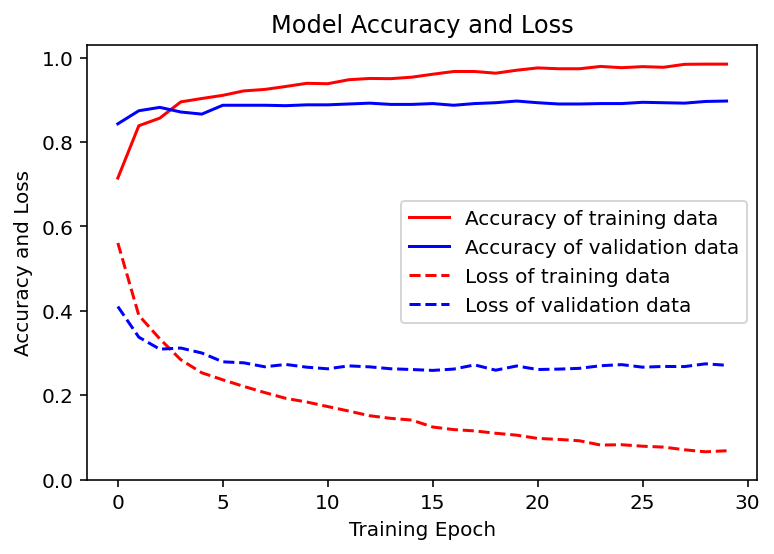

In [23]:
def show_4_graphs(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()
  
show_4_graphs(history)

### 과대적합이 발생한 것을 알 수 있다.
- 훈련 데이터가 부족하다
- 데이터 확장을 사용하여 개선할 수 있다.

### 2) 모델에 Dense망을 추가하고 학습을 수행
- 데이터 확장을 사용할 수 있다.
- 비용이 많이 든다
- 엔드-투-엔드로 실행한다

In [24]:
# 모델

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


## 학습을 동결하지 않으면 모두 재 학습된다!

In [25]:
conv_base.trainable = False

In [26]:
print(len(model.trainable_weights))

4


In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


### 컴파일을 수행해야 변경사항이 적용된다

In [28]:
train_datagen = ImageDataGenerator(
  rescale= 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True,
  fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
											   target_size=(img_width,img_height),
											   class_mode='binary',
											   batch_size=20)

validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
											   target_size=(img_width,img_height),
											   class_mode='binary',
											   batch_size=20)




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 과대적합이 줄어든 것을 볼 수 있다.

In [32]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

callbacks_list = [tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=30,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


100/100 [==============================] - 20s 192ms/step - loss: 0.3144 - accuracy: 0.8670 - val_loss: 0.2641 - val_accuracy: 0.8830
Epoch 2/30
100/100 [==============================] - 19s 191ms/step - loss: 0.3068 - accuracy: 0.8640 - val_loss: 0.2653 - val_accuracy: 0.8820
Epoch 3/30
100/100 [==============================] - 19s 191ms/step - loss: 0.3278 - accuracy: 0.8555 - val_loss: 0.2687 - val_accuracy: 0.8800
Epoch 4/30
100/100 [==============================] - 19s 189ms/step - loss: 0.3163 - accuracy: 0.8570 - val_loss: 0.2635 - val_accuracy: 0.8810


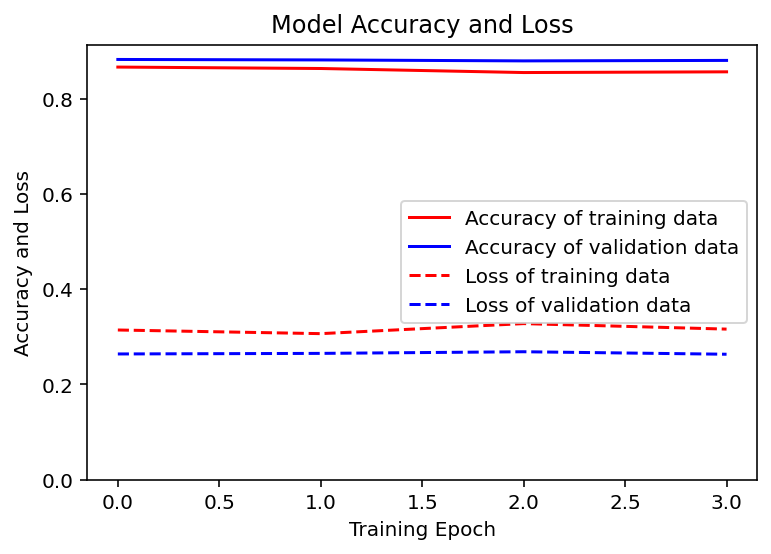

In [33]:
show_4_graphs(history)

## 미세조정 방법
- 상위 계층 몇개를 재학습시킨다
- 앞에서 소개한 절차, 즉, 전결합망(top)부분을 먼저 학습시킨 후에 상위계층의 미세조정을 해야 한다 (한번에 학습하면 안되고 두 단계로 나누어야 함)

         

In [34]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### 위에서 block 5 부분만 미세조정 하겠다

In [35]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

### 학습률을 작게 조정한다 (천천히 학습하도록)

In [36]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

callbacks_list = [tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=30,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


100/100 [==============================] - 22s 199ms/step - loss: 0.3092 - accuracy: 0.8695 - val_loss: 0.2360 - val_accuracy: 0.9030
Epoch 2/30
100/100 [==============================] - 20s 197ms/step - loss: 0.2789 - accuracy: 0.8825 - val_loss: 0.2498 - val_accuracy: 0.9070
Epoch 3/30
100/100 [==============================] - 20s 198ms/step - loss: 0.2485 - accuracy: 0.8935 - val_loss: 0.2003 - val_accuracy: 0.9240
Epoch 4/30
100/100 [==============================] - 21s 206ms/step - loss: 0.2298 - accuracy: 0.9025 - val_loss: 0.2080 - val_accuracy: 0.9270
Epoch 5/30
100/100 [==============================] - 20s 204ms/step - loss: 0.2034 - accuracy: 0.9195 - val_loss: 0.1803 - val_accuracy: 0.9270
Epoch 6/30
100/100 [==============================] - 20s 198ms/step - loss: 0.1927 - accuracy: 0.9295 - val_loss: 0.1878 - val_accuracy: 0.9300
Epoch 7/30
100/100 [==============================] - 20s 197ms/step - loss: 0.1869 - accuracy: 0.9195 - val_loss: 0.1862 - val_accuracy: 0.9

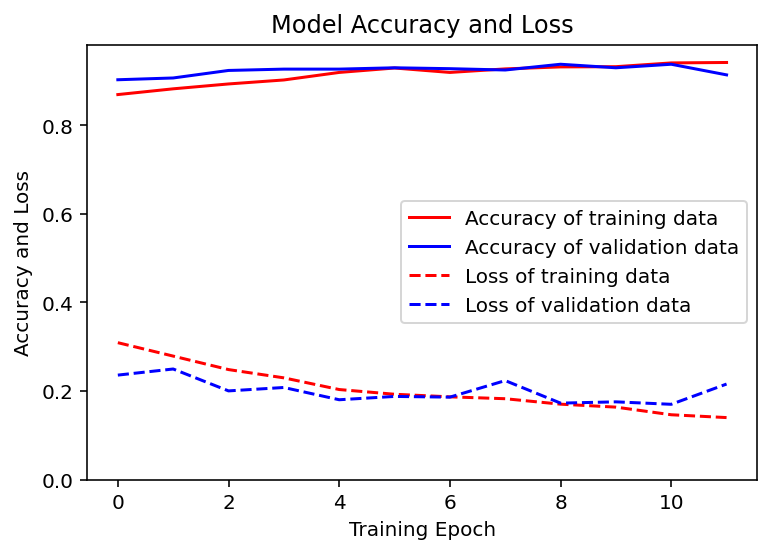

In [37]:
show_4_graphs(history)

## 성능이 92%로 1% 정도 향상되었다.
- 주의 할 것은 손실함수는 향상되지 않는 것으로 나타나도, 성능이 향상될 수 있다는 것이다. (분류 성능은 어떤 임계값만 넘으면 활률적으로 개선될 수 있다)

## 요약
- 과대적합을 줄이기 위해서 데이터 확장을 사용
- 전이학습 중 특성 추출방식 소개
- 전이학습 중 미세조정 방식 소개